In [1]:
from create_graphs_for_classification_task import CellGraphDataset

from torch_geometric.data import InMemoryDataset, Data
import torch_geometric.utils as utils
import torch
import os
import numpy as np
import pandas as pd
import polars as pl


Dataset: CellGraphDataset(315):
Number of graphs: 315
Number of features: 26
Number of classes: 2

Data(edge_index=[2, 102689], features=[6113, 26], weight=[102689], x=[6113, 26], y=[1], num_nodes=6113)
Number of nodes: 6113
Number of edges: 102689
Average node degree: 16.80
Has isolated nodes: True
Has self-loops: True
Is undirected: True


In [2]:
dataset = CellGraphDataset(root='.')

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:275]
test_dataset = dataset[275:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 275
Number of test graphs: 40


In [3]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 11151824], features=[516180, 26], weight=[11151824], x=[516180, 26], y=[64], num_nodes=516180, batch=[516180], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 11048373], features=[510035, 26], weight=[11048373], x=[510035, 26], y=[64], num_nodes=510035, batch=[510035], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10358094], features=[483848, 26], weight=[10358094], x=[483848, 26], y=[64], num_nodes=483848, batch=[483848], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10700845], features=[497305, 26], weight=[10700845], x=[497305, 26], y=[64], num_nodes=497305, batch=[497305], ptr=[65])

Step 5:
Number of graphs in the current batch: 19
DataBatch(edge_index=[2, 2851546], features=[134416, 26], weight=[2851546], x=[134416, 26], y=[19], num_nodes=134416, batch=[134416], ptr=[20])



In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)


#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = self.conv3(x, edge_index)

#         # 2. Readout layer
#         x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

#         # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
#         return x

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

criterion = torch.nn.NLLLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        # data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        # data = data.to(device)

        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

### For a single hold out test set

In [6]:
for epoch in range(1, 10):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6727, Test Acc: 0.6750
Epoch: 002, Train Acc: 0.8218, Test Acc: 0.8000
Epoch: 003, Train Acc: 0.9600, Test Acc: 0.9250
Epoch: 004, Train Acc: 0.9673, Test Acc: 0.9500
Epoch: 005, Train Acc: 0.9564, Test Acc: 0.9000
Epoch: 006, Train Acc: 0.9855, Test Acc: 0.9500
Epoch: 007, Train Acc: 0.9855, Test Acc: 0.9750
Epoch: 008, Train Acc: 0.9964, Test Acc: 0.9500
Epoch: 009, Train Acc: 1.0000, Test Acc: 0.9500


In [32]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(torch.device('cpu'))

In [7]:
def test_cm(loader):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:  # Iterate in batches over the training/test dataset.
        # data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        all_preds.extend(pred.tolist())
        all_labels.extend(data.y.tolist())

    return all_preds, all_labels


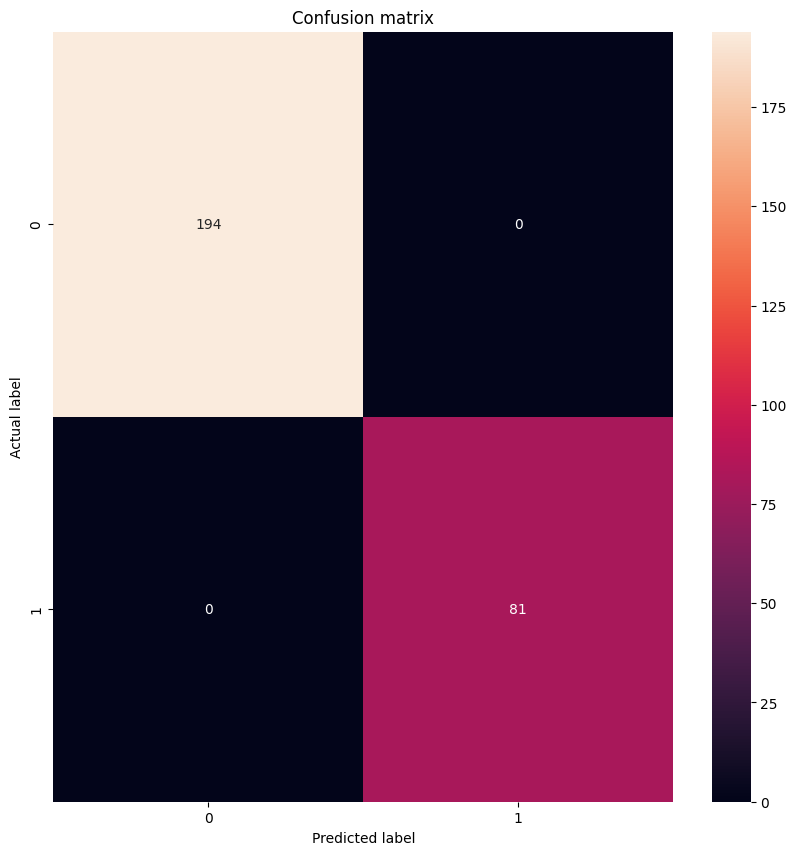

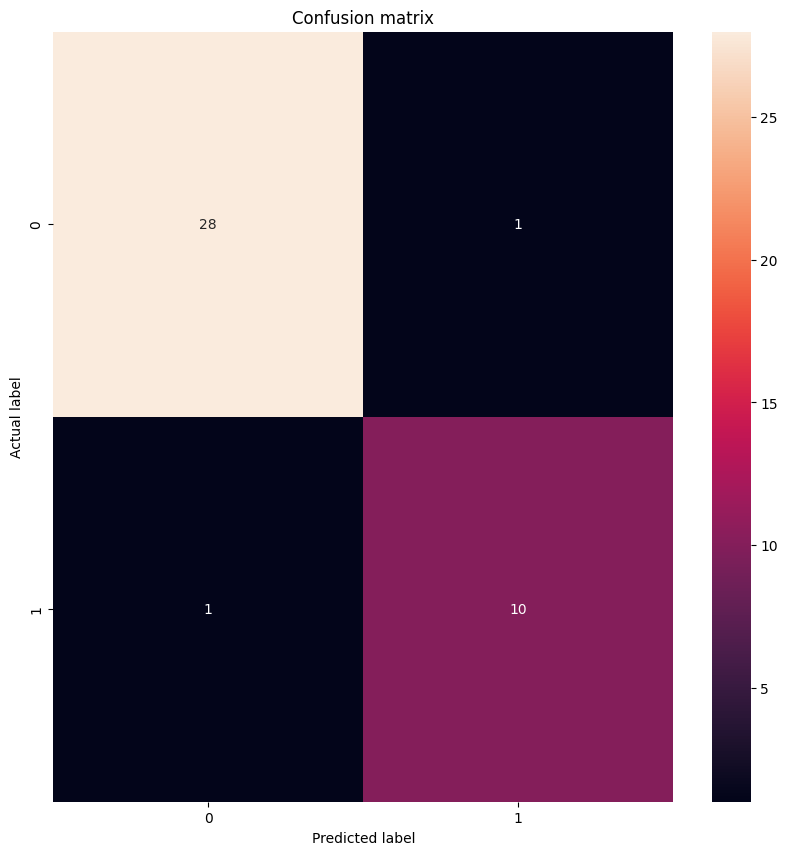

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Get predictions and true labels for both training and test sets
train_preds, train_labels = test_cm(train_loader)
test_preds, test_labels = test_cm(test_loader)

# Plot confusion matrices
plot_confusion_matrix(train_labels, train_preds)
plot_confusion_matrix(test_labels, test_preds)


In [9]:
from sklearn.metrics import classification_report

def evaluate_model(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    for data in loader:
        # data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        
        all_preds.append(pred.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    report = classification_report(all_labels, all_preds)
    print(report)

# Evaluate the model on the train and test loaders
print("Train Metrics:")
evaluate_model(model, train_loader)
print("Test Metrics:")
evaluate_model(model, test_loader)


Train Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       194
           1       1.00      1.00      1.00        81

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Test Metrics:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.91      0.91      0.91        11

    accuracy                           0.95        40
   macro avg       0.94      0.94      0.94        40
weighted avg       0.95      0.95      0.95        40



In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

def evaluate_model_met(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            # data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return {'precision': precision, 'recall': recall, 'f1-score': f1}


### k-Fold cross validation (k=5)

#### First, k fold for f1 score, precision, and recall

In [9]:
from torch.utils.data import random_split
from sklearn.metrics import f1_score, precision_score, recall_score

num_folds = 5
fold_size = len(dataset) // num_folds

# For reproducibility
torch.manual_seed(12345)
dataset = dataset.shuffle()

f1_scores = []
precision_scores = []
recall_scores = []

for fold in range(num_folds):
    # Create a copy of the dataset indices
    indices = torch.randperm(len(dataset))

    # Define the size of the train and test splits
    test_indices = indices[fold*fold_size:(fold+1)*fold_size]
    train_indices = torch.cat([indices[:fold*fold_size], indices[(fold+1)*fold_size:]])

    # Create data subsets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Define the model
    model = GCN(hidden_channels=64)#.to(device)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Define the loss function
    criterion = torch.nn.NLLLoss()

    # Train the model for each fold
    for epoch in range(1, 12):
        train()

    # Test the model for each fold and compute metrics
    train_report = evaluate_model_met(model, train_loader)
    test_report = evaluate_model_met(model, test_loader)

    # Extract F1 score for each fold and append to the list
    f1_scores.append((train_report['f1-score'], test_report['f1-score']))
    precision_scores.append((train_report['precision'], test_report['precision']))
    recall_scores.append((train_report['recall'], test_report['recall']))

# Print average metrics
print('Average F1 score:', np.mean(f1_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average Recall:', np.mean(recall_scores))


Average F1 score: 0.9668216923141101
Average Precision: 0.9712558861988454
Average Recall: 0.9645971765484239


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model_roc_auc(model, loader):
    model.eval()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            # data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)  
            
            # Extract probabilities for the positive class
            probas = out[:, 1].cpu().numpy()
            all_preds.extend(probas)
            
            all_labels.extend(data.y.cpu().numpy())

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


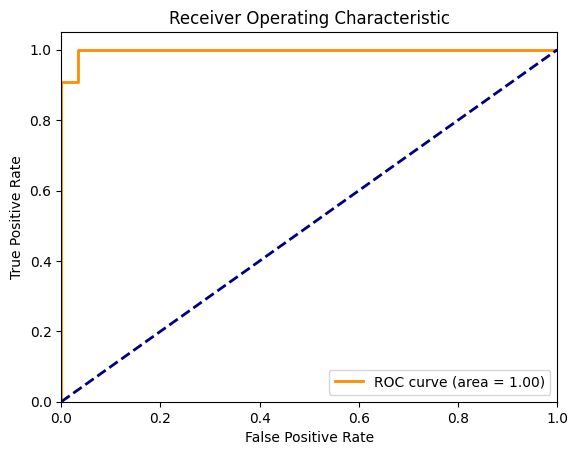

In [18]:
evaluate_model_roc_auc(model, test_loader)

### k fold for accuracy (and confusion matrix)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model_met_new(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            # data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return {'precision': precision, 'recall': recall, 'f1-score': f1, 'preds': all_preds, 'labels': all_labels}

# In the cross-validation loop
all_preds = []
all_labels = []

for fold in range(num_folds):
    # Create a copy of the dataset indices
    indices = torch.randperm(len(dataset))

    # Define the size of the train and test splits
    test_indices = indices[fold*fold_size:(fold+1)*fold_size]
    train_indices = torch.cat([indices[:fold*fold_size], indices[(fold+1)*fold_size:]])

    # Create data subsets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Define the model
    model = GCN(hidden_channels=64)#.to(device)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Define the loss function
    criterion = torch.nn.NLLLoss()

    # Train the model for each fold
    for epoch in range(1, 12):
        train()

    # Test the model for each fold and compute metrics
    train_report = evaluate_model_met_new(model, train_loader)
    test_report = evaluate_model_met_new(model, test_loader)

    all_preds.extend(test_report['preds'])
    all_labels.extend(test_report['labels'])


# Calculate overall accuracy and confusion matrix
overall_accuracy = accuracy_score(all_labels, all_preds)
confusion_mat = confusion_matrix(all_labels, all_preds)

print('Overall Accuracy:', overall_accuracy)
print('Confusion Matrix:')
print(confusion_mat)


Overall Accuracy: 0.9777777777777777
Confusion Matrix:
[[222   1]
 [  6  86]]


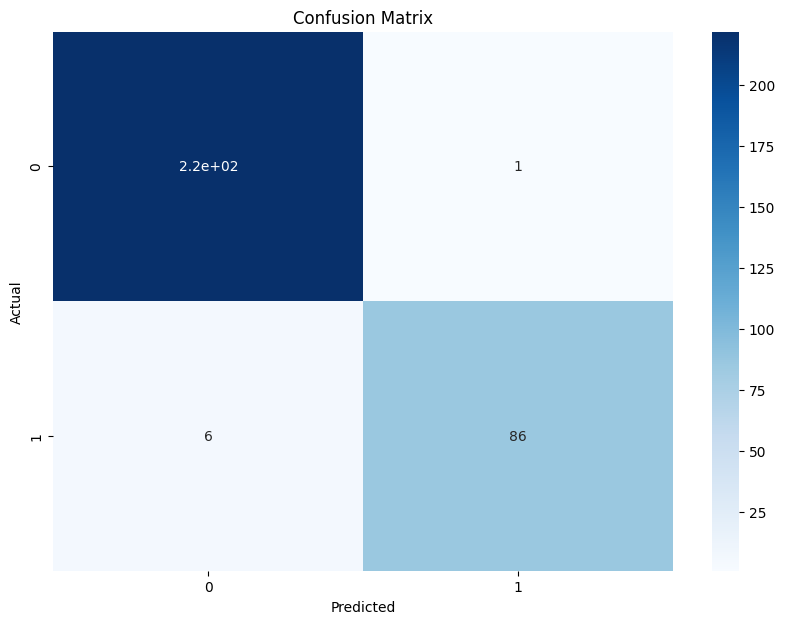

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize = (10,7))
    sns.heatmap(confusion_mat, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(confusion_mat)
